# Project: WeRateDogs Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#assessing">Assesing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I will analyze the dataset from the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. 
I will use three different sources, Enhanced Twitter Archive, Twitter Archive from Twitter API, and Image Predictions File.
After gathering all of the data for this project, I will clean and analyze it. 
In the end, I will give insights and visualizations of the analysis of the dataset. 

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import functools
%matplotlib inline

<a id='gathering'></a>
## Gathering Data

At this step, I begin the process of wrangling by gathering the required data. Three pieces of data need to be collected, as I mentioned at the beginning.

**1. twitter-archive-enhanced.csv**

In [2]:
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

**2. The Tweet Image Predictions**

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
folder_name = 'image-predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [5]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
        file.write(response.content)

In [6]:
os.listdir(folder_name)

['image-predictions.tsv']

In [7]:
image_pred_df = pd.read_csv(folder_name + '/image-predictions.tsv', sep='\t')

**3. The Twitter Archive from Twitter API**

In [8]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

In [9]:
consumer_key = 'dCDv6U3GwyiLuZUrr4jWfh58Q'
consumer_secret = 'wdkAS4D6uGLBIDtY4itOUkeMbwSkbXFYjaQFHSuMrOY20FtJFi'
access_token = '1329738051959070723-uVKeDw4UNrdWw35gnHu7j36pyNEYuK'
access_secret = 'moSOiZOrth7mPZ71sDAYTe3njhF7VUzGoFt2A3IhXODNq'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [10]:
tweet_ids = twitter_archive_df.tweet_id.values
#len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [11]:
tweet_json_data = []

with open('tweet_json.txt', 'r') as json_file:
    # read the first line to start the loop
    line = json_file.readline()
    while line:
        data = json.loads(line)

        # extract variables from the JSON data
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        
        # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count
                    }
        tweet_json_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- while -----

# convert the tweet JSON data dictionary list to a DataFrame
tweet_json_df = pd.DataFrame(tweet_json_data, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

<a id='assessing'></a>
## Assessing Data

After gathering each of the above pieces of data, I will assess them visually and programmatically for quality and tidiness issues. At the end of this part, I will show and conclude the quality and tidiness issues of these data.

**1. twitter_archive_df**

In [12]:
twitter_archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
992,748692773788876800,NaN,NaN,2016-07-01 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,his,doggo,None,None,None
1425,697943111201378304,NaN,NaN,2016-02-12 00:39:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She goes door to door trying t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697943111...,10,10,Cassie,None,None,None,None
1785,677644091929329666,NaN,NaN,2015-12-18 00:18:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a dog swinging. I really enjoyed it so...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677644091...,11,10,a,None,None,None,None
479,815745968457060357,NaN,NaN,2017-01-02 02:26:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Levi. He's a Madag...,7.914070e+17,4.196984e+09,2016-10-26 22:31:36 +0000,https://twitter.com/dog_rates/status/791406955...,12,10,Levi,None,None,None,None
814,771014301343748096,NaN,NaN,2016-08-31 15:58:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Another pic without a dog in it? What am I sup...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771014301...,7,10,None,None,None,None,None


In [13]:
twitter_archive_df['name'].value_counts()

None           745
a               55
Charlie         12
Lucy            11
Oliver          11
Cooper          11
Lola            10
Tucker          10
Penny           10
Bo               9
Winston          9
Sadie            8
the              8
an               7
Bailey           7
Buddy            7
Daisy            7
Toby             7
Jax              6
Stanley          6
Dave             6
Koda             6
Scout            6
Leo              6
Jack             6
Bella            6
Rusty            6
Oscar            6
Milo             6
Bentley          5
              ... 
Pepper           1
Grizzie          1
Deacon           1
Ember            1
Shakespeare      1
Dewey            1
Harlso           1
Rueben           1
Alf              1
Brandi           1
Dietrich         1
all              1
Amélie           1
Daniel           1
Trigger          1
Taz              1
Beemo            1
Eugene           1
Tuck             1
Darrel           1
Aiden            1
Patch       

In [14]:
twitter_archive_df[['rating_denominator','rating_numerator']].describe()

,rating_denominator,rating_numerator
count,2356.000000,2356.000000
mean,10.455433,13.126486
std,6.745237,45.876648
min,0.000000,0.000000
25%,10.000000,10.000000
50%,10.000000,11.000000
75%,10.000000,12.000000
max,170.000000,1776.000000


**twitter_archive_df quality issues:**
1. +0000 in timestamp
2. HTML tags in source
3. None is used for the unknown name instead of NaN
4. Some name are uncommon (ex: a, an, etc)
5. Invalid values in rating_denominator
6. Invalid values in rating_numerator

**twitter_archive_df tidiness issues:**
1. doggo, floofer, pupper, puppo can be gathered to a column 

**2. image_pred_df**

In [15]:
image_pred_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
38,666644823164719104,https://pbs.twimg.com/media/CUBl6IwVAAA9_zT.jpg,1,Ibizan_hound,0.044333,True,Pembroke,0.043209,True,West_Highland_white_terrier,0.038906,True
161,668932921458302977,https://pbs.twimg.com/media/CUiG6_ZXAAAPaw_.jpg,1,standard_poodle,0.237638,True,Old_English_sheepdog,0.195573,True,toy_poodle,0.144658,True
285,671147085991960577,https://pbs.twimg.com/media/CVBktzQXAAAPpUA.jpg,1,Yorkshire_terrier,0.467202,True,cairn,0.440122,True,silky_terrier,0.058690,True
1169,736010884653420544,https://pbs.twimg.com/media/CjbV-lEWgAAr6WY.jpg,2,golden_retriever,0.553901,True,Labrador_retriever,0.119475,True,bluetick,0.077475,True
225,670338931251150849,https://pbs.twimg.com/media/CU2FsRnVAAA3TEg.jpg,1,cairn,0.245033,True,West_Highland_white_terrier,0.137709,True,miniature_schnauzer,0.089173,True


In [16]:
image_pred_df[['img_num', 'p1_conf', 'p2_conf', 'p3_conf']].describe()

,img_num,p1_conf,p2_conf,p3_conf
count,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1.203855,0.594548,1.345886e-01,6.032417e-02
std,0.561875,0.271174,1.006657e-01,5.090593e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1.000000,0.843855,1.955655e-01,9.180755e-02
max,4.000000,1.000000,4.880140e-01,2.734190e-01


**image_pred_df quality issues:**
1. In p1,p2, and p3 words separated by _ instead of space 

**image_pred_df tidiness issues:**
1. We can reduce the prediction column to one by choosing the breed with the highest *_conf and true value in their *_dog column.

**3. image_pred_df**

In [17]:
tweet_json_df.sample(5)

,tweet_id,retweet_count,favorite_count
2280,666837028449972224,506,749
1111,728409960103686147,1921,4744
941,750429297815552001,4158,12878
1308,705475953783398401,877,2876
1575,686034024800862208,1102,2980


In [18]:
tweet_json_df[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2616.169884,7376.226083
std,4426.611200,11455.630509
min,1.000000,0.000000
25%,529.500000,1281.000000
50%,1222.000000,3200.000000
75%,3039.000000,9027.500000
max,75177.000000,152086.000000


**df_tweet_data_extra quality issues:**
N/A

**df_tweet_data_extra tidiness issues:**
N/A

**Check for quality issues by using df.info()**

In [19]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [20]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


**Quality issues:**
1. Not all of the data are in their most appropriate data type
2. The three dataframes do not have equal number of rows 
3. twitter_archive_df contains retweets and replies

**Check for duplicated data**

**1. twitter_archive_df**

In [22]:
twitter_archive_df.duplicated().sum()

0

In [23]:
twitter_archive_df['tweet_id'].duplicated().sum()

0

**2. image_pred_df**

In [24]:
image_pred_df.duplicated().sum()

0

In [25]:
image_pred_df['tweet_id'].duplicated().sum()

0

**3. tweet_json_df**

In [26]:
tweet_json_df.duplicated().sum()

0

In [27]:
tweet_json_df['tweet_id'].duplicated().sum()

0

## Summary of quality and tidiness issues:
**Quality:**


twitter_archive_df:
1. +0000 in timestamp
2. HTML tags in source
3. None is used for the unknown name instead of NaN
4. Some name are uncommon (ex: a, an, etc)
5. Invalid values in rating_denominator
6. Invalid values in rating_numerator
7. twitter_archive_df contains retweets and replies

image_pred_df:
8. In p1,p2, and p3 words separated by _ instead of space


for all dataframes:
9. Not all of the data are in their most appropriate data type


**Tidiness:**
1. Combine all of the dataframes into one dataframe

twitter_archive_df:
2. doggo, floofer, pupper, puppo can be gathered to a column

image_pred_df:
3. We can reduce the prediction column to one by choosing the breed with the highest *conf and true value in their *dog column.


<a id='cleaning'></a>
## Cleaning Data

In [28]:
twitter_archive_df_clean = twitter_archive_df.copy()
image_pred_df_clean = image_pred_df.copy()
tweet_json_df_clean = tweet_json_df.copy()

### Tidiness #1
**Merge dataframes**

In [100]:
master_df = pd.merge(twitter_archive_df_clean,image_pred_df_clean, on = ['tweet_id', 'tweet_id'], how='left')
master_df = pd.merge(master_df,tweet_json_df_clean, on = ['tweet_id', 'tweet_id'], how='left')

In [101]:
pd.set_option("display.max_columns",30)
master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7448.0,35293.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5532.0,30531.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3660.0,22983.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7618.0,38572.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8215.0,36858.0


**Check master_df.info()**

In [102]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

### Tidiness #2
**Create dog_type column**

In [103]:
dog_class = ['doggo', 'floofer', 'pupper', 'puppo']
master_df[dog_class] = master_df[dog_class].replace('None', '')

In [104]:
dog_type_cols = [master_df[x] for x in dog_class]
master_df['dog_type'] = functools.reduce(lambda col_main, col_add: col_main.str.cat(col_add, ', '), dog_type_cols)
master_df['dog_type'] = master_df['dog_type'].str.strip(', ')
master_df['dog_type'] = master_df['dog_type'].apply(lambda x: x.replace(', ', '', x.count(',')-1))
master_df['dog_type'] = master_df['dog_type'].replace('', np.nan)

# Drop columns
master_df = master_df.drop(columns=dog_class)

In [105]:
master_df['dog_type'].value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: dog_type, dtype: int64

In [106]:
master_df['dog_type'].isnull().sum()

1976

In [107]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        

### Tidiness #3
**Reduce the prediction column**

In [108]:
breed = []
conf = []

def breed_conf(row):
    if row['p1_dog'] == True:
        breed.append(row['p1'])
        conf.append(row['p1_conf'])
    elif row['p2_dog'] == True:
        breed.append(row['p2'])
        conf.append(row['p2_conf'])
    elif row['p3_dog'] == True:
        breed.append(row['p3'])
        conf.append(row['p3_conf'])
    else:
        breed.append(np.nan)
        conf.append(0)

master_df.apply(breed_conf, axis=1)
master_df['breed'] = breed
master_df['conf'] = conf

In [109]:
master_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_type,breed,conf
1203,716285507865542656,NaN,NaN,2016-04-02 15:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stephanus. She stays woke. 12/10 https://t.co/WIWabMngQZ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/716285507865542656/photo/1,https://twitter.com/dog_rates/status/716285507865542656/photo/1",12,10,Stephanus,https://pbs.twimg.com/media/CfDB3aJXEAAEZNv.jpg,1.0,Yorkshire_terrier,0.430420,True,silky_terrier,0.196769,True,cairn,0.072676,True,1008.0,2685.0,NaN,Yorkshire_terrier,0.430420
1430,697575480820686848,NaN,NaN,2016-02-11 00:18:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ole. He's not sure how to gravity. 8/10 https://t.co/PsqqotpBBQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697575480820686848/photo/1,8,10,Ole,https://pbs.twimg.com/media/Ca5JMvMUsAAGMll.jpg,1.0,Siamese_cat,0.256698,False,whippet,0.119805,True,bull_mastiff,0.102595,True,484.0,1982.0,NaN,whippet,0.119805
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6",NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,https://pbs.twimg.com/media/DDBIX9QVYAAohGa.jpg,1.0,basset,0.320420,True,collie,0.215975,True,Appenzeller,0.128507,True,1127.0,7093.0,NaN,basset,0.320420
2136,670055038660800512,NaN,NaN,2015-11-27 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tommy. He's a cool dog. Hard not to step on. Won't let go of seashell. Not fast by any means. 3/10 https://t.co/0gY6XTOpn3,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670055038660800512/photo/1,3,10,Tommy,https://pbs.twimg.com/media/CUyDgChWUAAmNSI.jpg,1.0,snail,0.563631,False,slug,0.296649,False,bolete,0.031839,False,301.0,623.0,NaN,NaN,0.000000
647,793135492858580992,NaN,NaN,2016-10-31 17:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Your favorite squad is looking extra h*ckin spooky today. 13/10 for all https://t.co/PrgvOyPtDT,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/793135492858580992/photo/1,https://twitter.com/dog_rates/status/793135492858580992/photo/1",13,10,None,https://pbs.twimg.com/media/CwHIg61WIAApnEV.jpg,1.0,bakery,0.737041,False,saltshaker,0.052396,False,teddy,0.046593,False,2476.0,6371.0,NaN,NaN,0.000000


In [110]:
col = ['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog']
master_df = master_df.drop(columns=col)

In [111]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
retweet_count                 2331 non-null float64
favorite_count                2331 non-null float64
dog_type                     

### Quality #1
**Remove +0000 from timestamp and change data type**

In [112]:
master_df.timestamp = master_df.timestamp.str.strip('+0000')

In [113]:
master_df.timestamp = pd.to_datetime(master_df.timestamp)

In [114]:
master_df.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,retweet_count,favorite_count,dog_type,breed,conf
1357,703407252292673536,NaN,NaN,2016-02-27 02:32:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pupper doesn't understand gates. 10/10 so close https://t.co/GUbFF4o6dZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703407252292673536/photo/1,10,10,None,https://pbs.twimg.com/media/CcMBJODUsAI5-A9.jpg,1.0,668.0,2366.0,pupper,NaN,0.0


In [115]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
retweet_count                 2331 non-null float64
favorite_count                2331 non-null float64
dog_type             

### Quality #2

**Remove HTML tags from source column**

In [116]:
sources = (master_df.source.str.extract('>(.*?)<').rename(columns={0: 'sources'}))
master_df['source'] = sources

In [117]:
master_df['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Quality #3
**Replace unknown name with NaN**

In [118]:
master_df.name = master_df.name.replace('None', np.nan)

In [119]:
master_df.name.loc[master_df.name == 'None'].sum()

False

### Quality #4
**Remove retweets and replies**

In [120]:
master_df = master_df[master_df['in_reply_to_status_id'].isnull()]

In [121]:
master_df = master_df[master_df['retweeted_status_id'].isnull()]

In [122]:
master_df = master_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

In [123]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
retweet_count         2090 non-null float64
favorite_count        2090 non-null float64
dog_type              336 non-null object
breed                 1666 non-null object
conf                  2097 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 262.1+ KB


### Quality #5
**Remove tweets that do not have retweet_count/favorite_count**


In [124]:
master_df = master_df[master_df['retweet_count'].notnull()]

In [125]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              2090 non-null int64
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  1487 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null float64
retweet_count         2090 non-null float64
favorite_count        2090 non-null float64
dog_type              335 non-null object
breed                 1659 non-null object
conf                  2090 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 261.2+ KB


### Quality #6
**Keep tweets that have an image**

In [126]:
master_df = master_df[master_df['jpg_url'].notnull()]

In [127]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1440 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null float64
retweet_count         1964 non-null float64
favorite_count        1964 non-null float64
dog_type              302 non-null object
breed                 1659 non-null object
conf                  1964 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 245.5+ KB


### Quality #7
**Invalid values in rating_denominator**

In [128]:
master_df['rating_denominator'].value_counts()

10     1947
50        3
80        2
11        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [129]:
temp = master_df[['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]
temp = temp[temp['rating_denominator'] != 10]

In [130]:
pd.set_option("display.max_colwidth",200)
temp

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


**Change the numerator and denominator manually from above analysis**

In [131]:
master_df.loc[master_df.tweet_id == 740373189193256964, 'rating_numerator'] = 14
master_df.loc[master_df.tweet_id == 740373189193256964, 'rating_denominator'] = 10

master_df.loc[master_df.tweet_id == 722974582966214656, 'rating_numerator'] = 13
master_df.loc[master_df.tweet_id == 722974582966214656, 'rating_denominator'] = 10

master_df.loc[master_df.tweet_id == 716439118184652801, 'rating_numerator'] = 11
master_df.loc[master_df.tweet_id == 716439118184652801, 'rating_denominator'] = 10

master_df.loc[master_df.tweet_id == 682962037429899265, 'rating_numerator'] = 10
master_df.loc[master_df.tweet_id == 682962037429899265, 'rating_denominator'] = 10

master_df.loc[master_df.tweet_id == 666287406224695296, 'rating_numerator'] = 9
master_df.loc[master_df.tweet_id == 666287406224695296, 'rating_denominator'] = 10

In [132]:
master_df['rating_denominator'].value_counts()

10     1952
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
7         1
Name: rating_denominator, dtype: int64

### Quality #8
**Invalid values in rating_numerator**

In [133]:
master_df['rating_numerator'].value_counts()

12      444
10      417
11      393
13      250
9       150
8        95
7        51
14       34
5        33
6        32
3        19
4        15
2         9
1         4
1776      1
420       1
24        1
26        1
27        1
44        1
45        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

From the information above we can conclude that 0 - 14 is a common value.
So, Let's check out the rows with rating_numerator > 14

In [134]:
temp = master_df[['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]
temp = temp[temp['rating_numerator'] > 14]

In [135]:
pd.set_option("display.max_colwidth",200)
temp

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


Some dog has a decimal numerator. Therefore, I decided to round the value to the nearest integer and update the dataframe manually.

In [136]:
master_df.loc[master_df.tweet_id == 786709082849828864, 'rating_numerator'] = 10
master_df.loc[master_df.tweet_id == 778027034220126208, 'rating_numerator'] = 11  
master_df.loc[master_df.tweet_id == 680494726643068929, 'rating_numerator'] = 11

In [137]:
master_df['rating_numerator'].value_counts()

12      444
10      418
11      395
13      250
9       150
8        95
7        51
14       34
5        33
6        32
3        19
4        15
2         9
1         4
1776      1
420       1
24        1
44        1
45        1
60        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

### Quality #9
**In breed column words separated by _ instead of space**

In [138]:
master_df['breed'] = master_df['breed'].str.replace('_', ' ')
master_df['breed'] = master_df['breed'].str.title()

In [139]:
master_df['breed'].sample(10)

69                              NaN
2140                         Beagle
177                        Malamute
1007       Chesapeake Bay Retriever
978            Old English Sheepdog
1993                            NaN
240                Golden Retriever
973                         Redbone
2126                          Cairn
1635    Soft-Coated Wheaten Terrier
Name: breed, dtype: object

### Quality #10
**Apply most appropriate data type to specific columns**

In [140]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1440 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null float64
retweet_count         1964 non-null float64
favorite_count        1964 non-null float64
dog_type              302 non-null object
breed                 1659 non-null object
conf                  1964 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 245.5+ KB


In [141]:
master_df['tweet_id'] = master_df['tweet_id'].astype(object)
master_df['img_num'] = master_df['img_num'].astype(int)
master_df['retweet_count'] = master_df['retweet_count'].astype(int)
master_df['favorite_count'] = master_df['favorite_count'].astype(int)

In [142]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1964 non-null object
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1440 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null int64
retweet_count         1964 non-null int64
favorite_count        1964 non-null int64
dog_type              302 non-null object
breed                 1659 non-null object
conf                  1964 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(8)
memory usage: 245.5+ KB


In [143]:
df = master_df.copy()
df.to_csv('twitter-archive-master.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

In [144]:
df.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,retweet_count,favorite_count,dog_type,breed,conf
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,7448,35293,NaN,NaN,0.000000
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,5532,30531,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,3660,22983,NaN,Chihuahua,0.716012


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1964 non-null object
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1440 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null int64
retweet_count         1964 non-null int64
favorite_count        1964 non-null int64
dog_type              302 non-null object
breed                 1659 non-null object
conf                  1964 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(8)
memory usage: 245.5+ KB


In [146]:
df.describe()

,rating_numerator,rating_denominator,img_num,retweet_count,favorite_count,conf
count,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000
mean,12.167006,10.456721,1.202138,2391.568228,8120.965377,0.465133
std,41.671588,6.801131,0.559615,4274.594596,11944.343149,0.339506
min,0.000000,7.000000,1.000000,11.000000,69.000000,0.000000
25%,10.000000,10.000000,1.000000,532.750000,1740.250000,0.140339
50%,11.000000,10.000000,1.000000,1158.500000,3667.000000,0.459560
75%,12.000000,10.000000,1.000000,2726.250000,10140.750000,0.776453
max,1776.000000,170.000000,4.000000,75177.000000,152086.000000,0.999956


### Top Dog Breeds Posted by WeRateDogs

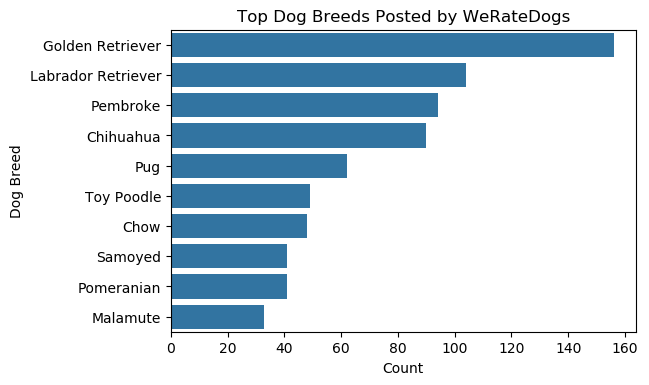

In [147]:
plt.figure(dpi=100);
sns.countplot(y="breed", data=df, color=sns.color_palette()[0],
              order=df['breed'].value_counts().iloc[:10].index);
plt.title('Top Dog Breeds Posted by WeRateDogs')
plt.xlabel('Count')
plt.ylabel('Dog Breed');

### Most Common Ratings Given by WeRateDogs

In [149]:
df['rating'] = master_df['rating_numerator'].astype(str) + "/" + master_df['rating_denominator'].astype(str)

In [150]:
df['rating'].value_counts()

12/10      444
10/10      418
11/10      395
13/10      250
9/10       150
8/10        95
7/10        51
14/10       34
5/10        33
6/10        32
3/10        19
4/10        15
2/10         9
1/10         4
121/110      1
165/150      1
144/120      1
1776/10      1
24/7         1
80/80        1
60/50        1
0/10         1
99/90        1
44/40        1
204/170      1
45/50        1
84/70        1
420/10       1
88/80        1
Name: rating, dtype: int64

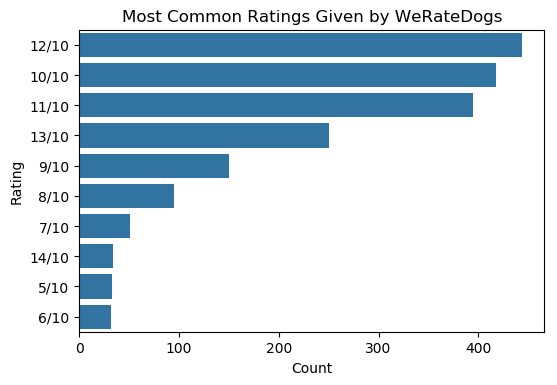

In [151]:
plt.figure(dpi=100);
sns.countplot(y="rating", data=df, color=sns.color_palette()[0],
              order=df['rating'].value_counts().iloc[:10].index);
plt.title('Most Common Ratings Given by WeRateDogs')
plt.xlabel('Count')
plt.ylabel('Rating');

The ratings given by WeRateDogs are mostly in the range of 5 to 14 out of 10. There is an upward trend from lower to higher ratings, with the most common rating being 12/10. The top three ratings which are 11/10, 10/10, and 12/10 are around 400 counts each out of roughly 2000 counts of the total data.

### Dog Breeds with the Highest Average Retweet Count

In [152]:
df.groupby('breed')['retweet_count'].mean().sort_values(ascending=False).nlargest(20)

breed
Bedlington Terrier         7086.166667
Afghan Hound               5050.000000
Standard Poodle            4729.363636
French Bulldog             4658.600000
English Springer           4645.500000
Saluki                     4372.000000
Whippet                    4347.000000
Cocker Spaniel             4190.066667
Eskimo Dog                 4104.636364
Samoyed                    4017.365854
Flat-Coated Retriever      3914.750000
Irish Water Spaniel        3826.666667
Great Pyrenees             3816.200000
Bouvier Des Flandres       3795.000000
Lakeland Terrier           3688.176471
Mexican Hairless           3623.428571
Tibetan Mastiff            3545.250000
Black-And-Tan Coonhound    3507.000000
Leonberg                   3269.666667
Golden Retriever           3232.467949
Name: retweet_count, dtype: float64

Based on the average retweet counts categorized by each breed, Bedlington Terrier has the highest average with over 7000 retweets, strongly leading above the second and third highest of 5050 and 4729 retweets for Afghan Hound and Standard Poodle. Almost all of the top 20 breeds with the highest average retweet count, however, are not in the top 10 breeds with the highest tweet counts posted by WeRateDogs. This indicates the high average might be due to a few tweets with unusually high number of retweets.

### Dog Breeds with the Highest Average Favorite Count

In [153]:
df.groupby('breed')['favorite_count'].mean().sort_values(ascending=False).nlargest(20)

breed
Bedlington Terrier         22568.666667
Saluki                     21711.250000
French Bulldog             18318.966667
Bouvier Des Flandres       16078.000000
Afghan Hound               15392.666667
Black-And-Tan Coonhound    15291.500000
Flat-Coated Retriever      15132.750000
Irish Water Spaniel        14614.000000
Leonberg                   13256.000000
Whippet                    13180.181818
English Springer           12684.000000
Standard Poodle            12489.000000
Cocker Spaniel             12310.233333
Samoyed                    12287.658537
Border Terrier             12185.571429
Mexican Hairless           12141.857143
Eskimo Dog                 11583.090909
Cardigan                   11437.380952
Golden Retriever           11303.762821
Lakeland Terrier           11289.764706
Name: favorite_count, dtype: float64

The dog breed with the highest average favorite counts is Bedlington Terrier, which also has the highest average retweets. Both Bedlington Terrier and Saluki, the second highest breed, have over 20000 average favorite counts for their respective tweets posted by WeRateDogs. Similar to the previous one, most of the top 20 breeds with the highest average favorite count are not the top 10 breeds with the highest number of tweets posted by WeRateDogs.

### Tweets Posted by WeRateDogs

In [154]:
df['month_year'] = pd.to_datetime(master_df['timestamp']).dt.to_period('M')

In [155]:
def Reverse(list): 
    return [val for val in reversed(list)] 

my_order = Reverse(df['month_year'].unique())

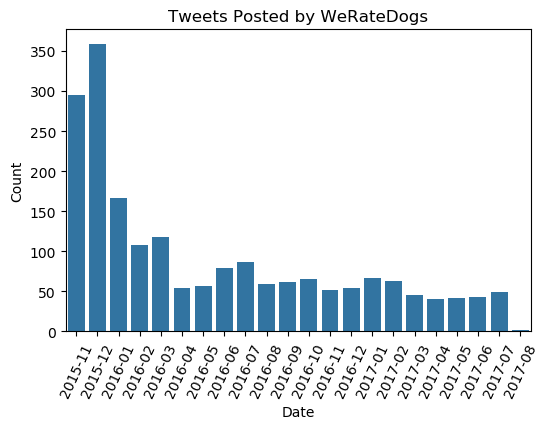

In [156]:
plt.figure(dpi=100);
base_col = sns.color_palette()[0]
sns.countplot(data = df,x='month_year', order = my_order, color = base_col);
plt.title('Tweets Posted by WeRateDogs');
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation = 65);

The chronological analysis of the number of tweets of WeRateDogs from November 2015 to August 2017 shows that the user is more active in the end of 2015 with almost 300 tweets in November and over 350 tweets in December. The numbers drop significantly to around 50 tweets per month for most of period included in the data. Factors contributing to this significant change is not known from our data, however, hence a causal relationship cannot be infered.